In [1]:
#Read dataset

import pandas as pd
import numpy as np

# Read main data
data = pd.read_excel('/Users/anthony/spyder-py3/ML/traffic_tg1.xlsx', index_col='date')
data.index = pd.to_datetime(data.index)

# Read holiday day data
holidays_data = pd.read_excel('/Users/anthony/spyder-py3/ML/public_holiday.xlsx')
holidays_data['date'] = pd.to_datetime(holidays_data['date'])


In [2]:
#Create dummies

# Create a dummy for holiday
data['is_holiday'] = data.index.isin(holidays_data['date']).astype(int)

# Create a dummy for sunday
data['is_sunday'] = (data.index.dayofweek == 6).astype(int)

In [3]:
#Create CNN model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Flatten

# Define a function to create a sequential CNN model
def create_cnn_model(filters, kernel_size, activation, n_steps_in, n_features, optimizer):
    model = Sequential()
    model.add(Conv1D(filters=filters, 
                     kernel_size=kernel_size, 
                     activation=activation, 
                     input_shape=(n_steps_in, n_features)))
    model.add(Conv1D(filters=filters, 
                     kernel_size=7, 
                     activation=activation))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mape','mae','mse'], run_eagerly=True)
    return model

In [4]:
#Transform data
from sklearn.preprocessing import MinMaxScaler

# Scale data between 0 and 1
def scale_data(data):
    scalers = {}
    data_normalized = data.copy()
    for column in data.columns:
        scaler = MinMaxScaler()
        data_normalized[column] = scaler.fit_transform(data[[column]])
        scalers[column] = scaler
    return data_normalized, scalers


# Define a function to transfrom data for CNN model
def transform_data_cnn(data_normalized, n_steps_in, start_date, end_date):    
    X, y, dates = [], [], []
    # Filter data based on the start and end dates
    data_filtered = data_normalized[start_date:end_date]
    # Create sequence data of n_steps_in days and n_steps_out days
    for i in range(n_steps_in, len(data_filtered)):
        X.append(data_filtered.iloc[i-n_steps_in:i])
        y.append(data_filtered.iloc[i]['tg1_traffic']) #0 because we just want to predict traffic
        dates.append(data_filtered.index[i])
    X, y, dates = np.array(X), np.array(y), np.array(dates)
    return X, y, dates




In [19]:
#Prepare data


data = data[(data.index.dayofweek != 5) & (data.index.dayofweek != 6)]




data_normalized, scaler = scale_data(data)
n_steps_in =260

X_train, y_train, train_dates = transform_data_cnn(data, 
                                                   n_steps_in,  
                                                   '2017-01-01', 
                                                   '2019-12-31')
X_val, y_val, val_dates = transform_data_cnn(data_normalized,
                                             n_steps_in,
                                             '2020-01-01',
                                             '2021-12-31')
X_test, y_test, test_dates = transform_data_cnn(data_normalized, 
                                                n_steps_in, 
                                                '2022-01-01', 
                                                '2023-01-15')

In [9]:
# Train model

from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping (stop after 5 consecutives epochs if no improvement)
#early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model
cnn_model = create_cnn_model(filters=32, 
                             kernel_size=7, 
                             activation='relu', 
                             n_steps_in=n_steps_in, 
                             n_features=3, 
                             optimizer='adam')
history = cnn_model.fit(X_train, 
                        y_train, 
                        epochs=20, 
                        verbose=1, 
                        validation_data=(X_val, y_val)) 
                        #,callbacks=[early_stopping])

# Evaluate the model on the test data
test_loss, test_mape, test_mae, test_mse = cnn_model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss:.4f}, Test MAPE: {test_mape:.4f}, Test MAE: {test_mae:.4f}, Test MSE: {test_mse:.4f}')

# Make predictions
y_train_pred = cnn_model.predict(X_train)
y_val_pred = cnn_model.predict(X_val)
y_test_pred = cnn_model.predict(X_test)




Epoch 1/20


2023-08-16 07:58:40.018592: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-08-16 07:58:40.018648: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-08-16 07:58:40.018653: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-08-16 07:58:40.019190: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-16 07:58:40.019553: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


23/23 [==============================] - 1s 26ms/step - loss: 96911584.0000 - mape: 1579168301056.0000 - mae: 7259.4893 - mse: 96911584.0000 - val_loss: 0.0231 - val_mape: 35983780.0000 - val_mae: 0.1189 - val_mse: 0.0231
Epoch 2/20
23/23 [==============================] - 0s 21ms/step - loss: 37458500.0000 - mape: 522221191168.0000 - mae: 4065.9233 - mse: 37458500.0000 - val_loss: 0.0141 - val_mape: 23520116.0000 - val_mae: 0.0873 - val_mse: 0.0141
Epoch 3/20
23/23 [==============================] - 0s 21ms/step - loss: 34436828.0000 - mape: 450733342720.0000 - mae: 3803.6733 - mse: 34436828.0000 - val_loss: 0.0137 - val_mape: 33397586.0000 - val_mae: 0.0905 - val_mse: 0.0137
Epoch 4/20
23/23 [==============================] - 0s 21ms/step - loss: 34572776.0000 - mape: 544801619968.0000 - mae: 3870.0151 - mse: 34572776.0000 - val_loss: 0.0158 - val_mape: 28682452.0000 - val_mae: 0.0960 - val_mse: 0.0158
Epoch 5/20
23/23 [==============================] - 0s 21ms/step - loss: 34555032.

In [ ]:
import matplotlib.pyplot as plt
# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(train_dates, y_train, label='Training data')
plt.plot(val_dates, y_val, label='Validation data')
plt.plot(test_dates, y_test, label='Test data')
plt.plot(train_dates, y_train_pred, label='Predicted training data')
plt.plot(val_dates, y_val_pred, label='Predicted validation data')
plt.plot(test_dates, y_test_pred, label='Predicted test data')
plt.legend()
plt.show()


In [ ]:
def retrain_from_scratch(X_train, y_train, n_steps_in, model_params, test_dates, y_test):
    cnn_model = create_cnn_model(**model_params)
    daily_predictions = []
    eight_day_predictions = [0] * len(test_dates)
    

    for i, date in enumerate(test_dates):
        # Ajoutez la vraie valeur du jour précédent à l'ensemble de formation
        # et réentrainez le modèle à partir de zéro
        new_X, new_y = X_train[-1][1:], y_train[-1]
        if i == 0:
            new_traffic_point = y_train[-1]
        else:
            new_traffic_point = y_test[i-1]

        current_date = test_dates[i]
        is_holiday = 1 if current_date in holidays_data['date'].values else 0
        is_sunday = 1 if current_date.dayofweek == 6 else 0

        # Créez un nouveau point de données avec le trafic et les dummies
        new_data_point = [new_traffic_point, is_holiday, is_sunday]
        new_data_point_array=np.array([new_data_point])
        # Mettez à jour la fenêtre glissante
        new_X = np.append(new_X, new_data_point_array, axis=0)
        
        X_train = np.append(X_train, [new_X], axis=0)
        y_train = np.append(y_train, [new_y])

        
        print('Training for ',current_date)
        cnn_model.fit(X_train, y_train, epochs=20, verbose=0)

        # Prédiction pour le jour suivant
        prediction = cnn_model.predict(X_train[-1].reshape(1, n_steps_in, 3))
        daily_predictions.append(prediction[0])

        # Si le jour actuel est un jeudi, prédisez les 8 jours suivants
        if date.weekday() == 3:
            eight_days_data = X_train[-1]
            local_predictions = []
            for _ in range(8):
                current_date = test_dates[i] + pd.Timedelta(days=1)
                is_holiday = 1 if current_date in holidays_data['date'].values else 0
                is_sunday = 1 if current_date.dayofweek == 6 else 0

                # Créez un nouveau point de données avec le trafic et les dummies
                new_prediction_point = [prediction[0][0], is_holiday, is_sunday]
                new_prediction_point_array = np.array([new_prediction_point])
                eight_days_data = np.append(eight_days_data[1:], new_prediction_point_array, axis=0)
                prediction = cnn_model.predict(eight_days_data.reshape(1, n_steps_in, 3))
                local_predictions.append(prediction[0])
            for j in range(5):
                index_to_assign = i+3+j
                if index_to_assign < len(eight_day_predictions):
                    eight_day_predictions[index_to_assign] = local_predictions[3+j][0]

    return daily_predictions, eight_day_predictions


In [10]:
def transfer_learning(X_train, y_train, n_steps_in, model_params, test_dates, y_test, cnn_model):
    # Initialize empty list to save forecast
    daily_predictions = []
    eight_day_predictions = [0] * len(test_dates)
    
    for i, date in enumerate(test_dates):
        
        # Get traffic of last day to update X_train
        if i == 0:
            new_traffic_point = y_train[-1] # for first forecast, need to take last traffic in train data
        else:
            new_traffic_point = y_test[i-1]
            
        # Create dummies for new datapoint
        current_date = test_dates[i]
        is_holiday = 1 if current_date in holidays_data['date'].values else 0
        is_sunday = 1 if current_date.dayofweek == 6 else 0

        # Create new data point with traffic and dummies
        new_data_point = [new_traffic_point, is_holiday, is_sunday]
        new_data_point_array=np.array([new_data_point])

        # Update X_train and y_train
        new_X = np.append(X_train[-1][1:], new_data_point_array, axis=0)
        X_train = np.append(X_train, [new_X], axis=0)
        y_train = np.append(y_train, [y_test[i]])
    
        # Quick update of model for learning transfer
        print('Training for ',current_date)
        cnn_model.fit(X_train, y_train, epochs=1, verbose=0)

        # Make 1-day forecast
        
        prediction = cnn_model.predict(X_train[-1].reshape(1, n_steps_in, 3)) 
        daily_predictions.append(prediction[0])
        
        # if current date is a Thursday, need to make a 8-day forecast
        if date.weekday() == 3:
            eight_days_data = X_train[-1]
            local_predictions = []
            for _ in range(8):
                current_date = test_dates[i] 
                is_holiday = 1 if current_date in holidays_data['date'].values else 0
                is_sunday = 1 if current_date.dayofweek == 6 else 0

                # Créez un nouveau point de données avec le trafic et les dummies
                new_prediction_point = [prediction[0][0], is_holiday, is_sunday]
                new_prediction_point_array = np.array([new_prediction_point])
                eight_days_data = np.append(eight_days_data[1:], new_prediction_point_array, axis=0)
                prediction = cnn_model.predict(eight_days_data.reshape(1, n_steps_in, 3))
                local_predictions.append(prediction[0])
            for j in range(5):
                index_to_assign = i+3+j
                if index_to_assign < len(eight_day_predictions):
                    eight_day_predictions[index_to_assign] = local_predictions[3+j][0]




    return daily_predictions, eight_day_predictions


In [63]:
def transfer_learningv2(X_train, y_train, n_steps_in, model_params, test_dates, y_test, cnn_model):
    # Initialize empty list to save forecast
    daily_predictions = []
    eight_day_predictions = [0] * len(test_dates)
    
    for i, date in enumerate(test_dates):
        
        # Get traffic of last day to update X_train
        if i == 0:
            new_traffic_point = y_train[-1] # for first forecast, need to take last traffic in train data
        else:
            new_traffic_point = y_test[i-1]
            
        # Create dummies for new datapoint
        current_date = test_dates[i] # forecast's day
        is_holiday = 1 if current_date in holidays_data['date'].values else 0
        is_sunday = 1 if current_date.dayofweek == 6 else 0

        # Create new data point with traffic and dummies
        new_data_point = [new_traffic_point, is_holiday, is_sunday]
        new_data_point_array=np.array([new_data_point])

        # Update X_train and y_train
        new_X = np.append(X_train[-1][1:], new_data_point_array, axis=0)
        X_train = np.append(X_train, [new_X], axis=0)
        y_train = np.append(y_train, [y_test[i]])
    
        # Quick update of model for learning transfer
        print('Training for ',current_date)
        cnn_model.fit(X_train, y_train, epochs=1, verbose=0)

        # Make 1-day forecast
        
        prediction = cnn_model.predict(X_train[-1].reshape(1, n_steps_in, 3)) 
        daily_predictions.append(prediction[0])
        
        # if current date is a Thursday, need to make a 8-day forecast
        if date.weekday() == 3:
            eight_days_data = X_train[-1]
            local_predictions = []
            for k in range(6):
                if i + k < len(test_dates):  # Check that the index does not go beyond the length of test_dates
                    current_date = test_dates[i+k]
                    print(current_date)
                    is_holiday = 1 if current_date in holidays_data['date'].values else 0
                    is_sunday = 1 if current_date.dayofweek == 6 else 0

                    # Créez un nouveau point de données avec le trafic et les dummies
                    new_prediction_point = [prediction[0][0], is_holiday, is_sunday]
                    new_prediction_point_array = np.array([new_prediction_point])
                    eight_days_data = np.append(eight_days_data[1:], new_prediction_point_array, axis=0)
                    prediction = cnn_model.predict(eight_days_data.reshape(1, n_steps_in, 3))
                    local_predictions.append(prediction[0])
            for j in range(min(5, len(local_predictions)-1)):
                index_to_assign = i+2+j
                print(index_to_assign)
                if index_to_assign < len(eight_day_predictions):
                    eight_day_predictions[index_to_assign] = local_predictions[1+j][0]




    return daily_predictions, eight_day_predictions



In [ ]:
import matplotlib.pyplot as plt


# Get the traffic scaler
traffic_scaler = scaler['tg1_traffic']

# Reshape the predictions and the targets to the original shape
y_train_pred_rescaled = traffic_scaler.inverse_transform(y_train_pred)
y_train_rescaled = traffic_scaler.inverse_transform(y_train.reshape(-1,1))

y_val_pred_rescaled = traffic_scaler.inverse_transform(y_val_pred)
y_val_rescaled = traffic_scaler.inverse_transform(y_val.reshape(-1,1))

y_test_pred_rescaled = traffic_scaler.inverse_transform(y_test_pred)
y_test_rescaled = traffic_scaler.inverse_transform(y_test.reshape(-1,1))


In [ ]:
# Plot the training predictions
plt.figure(figsize=(14, 5))
plt.plot(train_dates, y_train_rescaled, label='True')
plt.plot(train_dates, y_train_pred_rescaled, label='Predicted')
plt.title('Training Data Predictions')
plt.legend()
plt.show()

# Plot the validation predictions
plt.figure(figsize=(14, 5))
plt.plot(val_dates, y_val_rescaled, label='True')
plt.plot(val_dates, y_val_pred_rescaled, label='Predicted')
plt.title('Validation Data Predictions')
plt.legend()
plt.show()

# Plot the test predictions
plt.figure(figsize=(14, 5))
plt.plot(test_dates, y_test_rescaled, label='True')
plt.plot(test_dates, y_test_pred_rescaled, label='Predicted')
plt.title('Test Data Predictions')
plt.legend()
plt.show()



In [ ]:
# Convert the dates to datetime
val_dates = pd.to_datetime(val_dates)

# Create a mask for the desired date range
mask = (val_dates >= '2021-06-15') & (val_dates <= '2021-06-30')

# Apply the mask to the dates, the true values and the predicted values
val_dates_range = val_dates[mask]
y_val_rescaled_range = y_val_rescaled[mask]
y_val_pred_rescaled_range = y_val_pred_rescaled[mask]

# Plot the true and predicted values for the desired date range
plt.figure(figsize=(14, 5))
plt.plot(val_dates_range, y_val_rescaled_range, label='True')
plt.plot(val_dates_range, y_val_pred_rescaled_range, label='Predicted')
plt.title('Validation Data Predictions for 15/06/2021 to 30/06/2021')
plt.legend()
plt.show()




In [ ]:
import matplotlib.pyplot as plt

# Historique des pertes
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Créez un masque pour filtrer les valeurs où y_true est égal à zéro
mask_train = y_train_rescaled != 0
mask_val = y_val_rescaled != 0
mask_test = y_test_rescaled != 0

# Calculez le MAPE en excluant les valeurs où y_true est égal à zéro
mape_train = np.mean(np.abs(y_train_rescaled[mask_train] - y_train_pred_rescaled[mask_train]) / y_train_rescaled[mask_train] * 100)
mape_val = np.mean(np.abs(y_val_rescaled[mask_val] - y_val_pred_rescaled[mask_val]) / y_val_rescaled[mask_val] * 100)
mape_test = np.mean(np.abs(y_test_rescaled[mask_test] - y_test_pred_rescaled[mask_test]) / y_test_rescaled[mask_test] * 100)

# Affichez les valeurs de MAPE
print(f'MAPE on Training Data: {mape_train:.2f}%')
print(f'MAPE on Validation Data: {mape_val:.2f}%')
print(f'MAPE on Test Data: {mape_test:.2f}%')


In [64]:
import time
from tensorflow.keras.optimizers import legacy

#X_train_complete = np.concatenate((X_train, X_val), axis=0)
#y_train_complete = np.concatenate((y_train, y_val), axis=0)

X_train_complete, y_train_complete, train_complete_dates = transform_data_cnn(data_normalized, 
                                                   n_steps_in,  
                                                   '2017-01-01', 
                                                   '2021-12-31')


# Paramètres du modèle
model_params = {
    "filters": 32,
    "kernel_size": 7,
    "activation": "relu",
    "n_steps_in": n_steps_in,
    "n_features": 3,
    "optimizer": 'adam'
}

# Réentrainement à partir de zéro
#start_time = time.time()

#daily_predictions_zero, eight_day_predictions_zero = retrain_from_scratch(X_train_complete,y_train_complete,n_steps_in,model_params,test_dates,y_test)

#print("--- Réentrainement à partir de zéro: %s seconds ---" % (time.time() - start_time))

# Transfert d'apprentissage
cnn_model = create_cnn_model(**model_params)
cnn_model.fit(X_train_complete, y_train_complete, epochs=20, verbose=0)
y_test_pred = cnn_model.predict(X_test)

start_time = time.time()
daily_predictions_transfer, eight_day_predictions_transfer = transfer_learningv2(X_train_complete,y_train_complete,n_steps_in,model_params,test_dates,y_test,cnn_model)
print("--- Transfert d'apprentissage: %s seconds ---" % (time.time() - start_time))


1/1 [==============================] - 0s 23ms/step
Training for  2023-01-02 00:00:00
1/1 [==============================] - 0s 16ms/step
Training for  2023-01-03 00:00:00
1/1 [==============================] - 0s 12ms/step
Training for  2023-01-04 00:00:00
1/1 [==============================] - 0s 17ms/step
Training for  2023-01-05 00:00:00
1/1 [==============================] - 0s 11ms/step
2023-01-05 00:00:00
1/1 [==============================] - 0s 12ms/step
2023-01-06 00:00:00
1/1 [==============================] - 0s 12ms/step
2023-01-09 00:00:00
1/1 [==============================] - 0s 11ms/step
2023-01-10 00:00:00
1/1 [==============================] - 0s 10ms/step
2023-01-11 00:00:00
1/1 [==============================] - 0s 11ms/step
2023-01-12 00:00:00
1/1 [==============================] - 0s 10ms/step
5
6
7
8
9
Training for  2023-01-06 00:00:00
1/1 [==============================] - 0s 15ms/step
Training for  2023-01-09 00:00:00
1/1 [==============================] - 0s 

In [ ]:
y_train_complete_pred = cnn_model.predict(X_train_complete)

In [ ]:
import pandas as pd

# Convertir les dates en une série pandas
date_series = pd.Series(train_complete_dates)

# Créer un masque booléen pour filtrer les dates
mask = (date_series >= '2021-01-01') & (date_series <= '2021-01-15')

# Filtrer les dates et les valeurs correspondantes
filtered_dates = date_series[mask].tolist()
filtered_y_train_complete = pd.Series(y_train_complete)[mask].tolist()
filtered_y_train_complete_pred = pd.Series(y_train_complete_pred.ravel())[mask].tolist()

# Afficher les résultats
plt.figure(figsize=(14, 5))
plt.plot(filtered_dates, filtered_y_train_complete, label='Training data')
plt.plot(filtered_dates, filtered_y_train_complete_pred, label='Predicted training data')
plt.legend()
plt.show()




In [ ]:
daily_predictions_transfer, eight_day_predictions_transfer = transfer_learning(X_train_complete,y_train_complete,n_steps_in,model_params,test_dates,y_test,cnn_model)
print("--- Transfert d'apprentissage: %s seconds ---" % (time.time() - start_time))

In [56]:
def plot_results(test_dates, y_test, y_test_pred, daily_predictions, eight_day_predictions, title):
    plt.figure(figsize=(15, 7))
    
    # Affichage du trafic réel
    plt.plot(test_dates, y_test, label='Trafic réel', color='blue', linestyle='dashed')
    
    # Affichage de la prévision lancée d'un coup
    plt.plot(test_dates, y_test_pred, label='Prévision globale', color='green')
    
    # Affichage de la prévision jour par jour
    plt.plot(test_dates, daily_predictions, label='Prévision ajustée', color='red')
    
    # Affichage de la prévision jour par jour
    plt.plot(test_dates, eight_day_predictions, label='Prévision hebdomadaire', color='purple')
    
    # Adjust the x-axis to show only weekdays
    ax = plt.gca()  # get current axis
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=(mdates.MO, mdates.TU, mdates.WE, mdates.TH, mdates.FR)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
    plt.xticks(rotation=45)  # rotate the x-axis labels for better visibility
    
    # Ajoute des tirets verticaux pour les vendredis
    for date in test_dates:
        if date.dayofweek == 4:  # Le vendredi correspond à 4
            plt.axvline(x=date, color='gray', linestyle='--', linewidth=0.5)
    
    
    plt.title(title)
    plt.legend()
    plt.show()



In [65]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# Fonction pour rescaler les prédictions à leur échelle d'origine
def rescale_predictions(predictions, scaler):
    predictions_array = np.array(predictions)
    return scaler.inverse_transform(predictions_array.reshape(-1, 1))

# Rescale des prédictions pour la méthode de réentrainement à partir de zéro
y_test_pred_rescaled = rescale_predictions(y_test_pred, scaler['tg1_traffic'])
y_test_rescaled = rescale_predictions(y_test, scaler['tg1_traffic'])
#daily_predictions_zero_rescaled = rescale_predictions(daily_predictions_zero, scaler['tg1_traffic'])
#eight_day_predictions_zero_rescaled = rescale_predictions(eight_day_predictions_zero, scaler['tg1_traffic'])

# Rescale des prédictions pour la méthode de transfert d'apprentissage

daily_predictions_transfer_rescaled = rescale_predictions(daily_predictions_transfer, scaler['tg1_traffic'])
eight_day_predictions_transfer_rescaled = rescale_predictions(eight_day_predictions_transfer, scaler['tg1_traffic'])




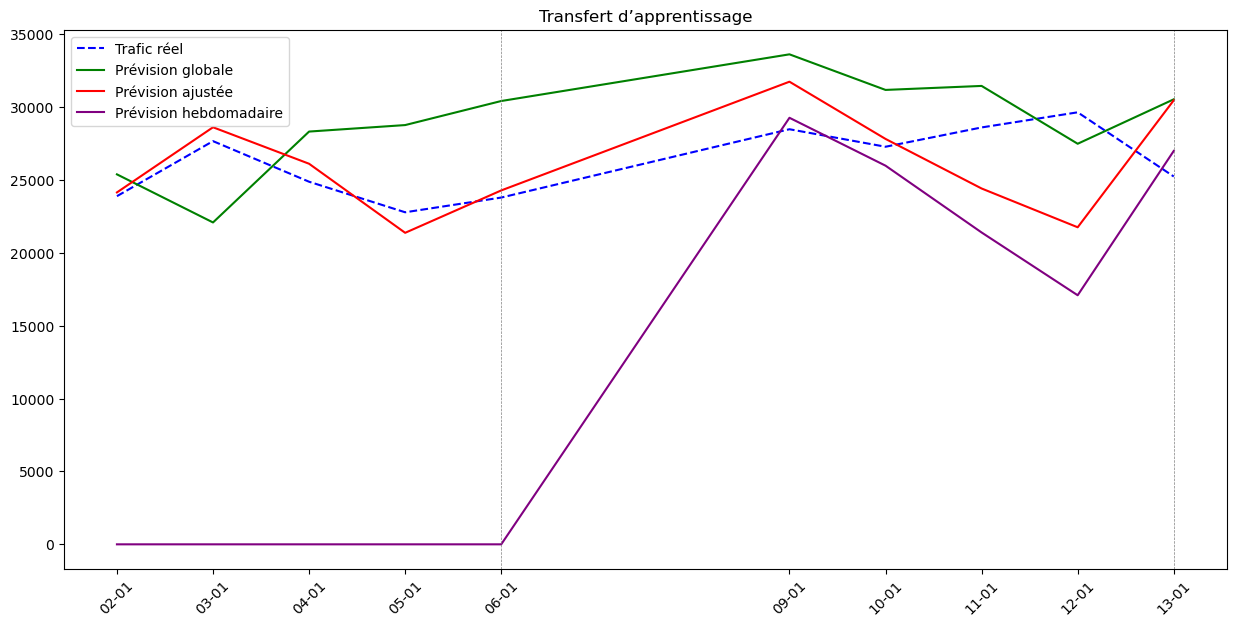

In [70]:
# Utilisation de la fonction plot_results avec les prédictions rescalées
#plot_results(test_dates, y_test_rescaled, y_test_pred_rescaled, daily_predictions_zero_rescaled, eight_day_predictions_zero_rescaled, 'Réentrainement à partir de zéro')
plot_results(test_dates, y_test_rescaled, y_test_pred_rescaled, daily_predictions_transfer_rescaled, eight_day_predictions_transfer_rescaled, 'Transfert d’apprentissage')

In [51]:
print(eight_day_predictions_transfer_rescaled)

[[    0.        ]
 [    0.        ]
 [    0.        ]
 [    0.        ]
 [29994.44986939]
 [31314.85376751]
 [23275.60205698]
 [17254.57062364]
 [29001.79794145]
 [    0.        ]]


In [52]:
print(test_dates)

[Timestamp('2023-01-02 00:00:00') Timestamp('2023-01-03 00:00:00')
 Timestamp('2023-01-04 00:00:00') Timestamp('2023-01-05 00:00:00')
 Timestamp('2023-01-06 00:00:00') Timestamp('2023-01-09 00:00:00')
 Timestamp('2023-01-10 00:00:00') Timestamp('2023-01-11 00:00:00')
 Timestamp('2023-01-12 00:00:00') Timestamp('2023-01-13 00:00:00')]


In [67]:
y_train_pred = cnn_model.predict(X_train_complete)

33/33 [==============================] - 0s 4ms/step


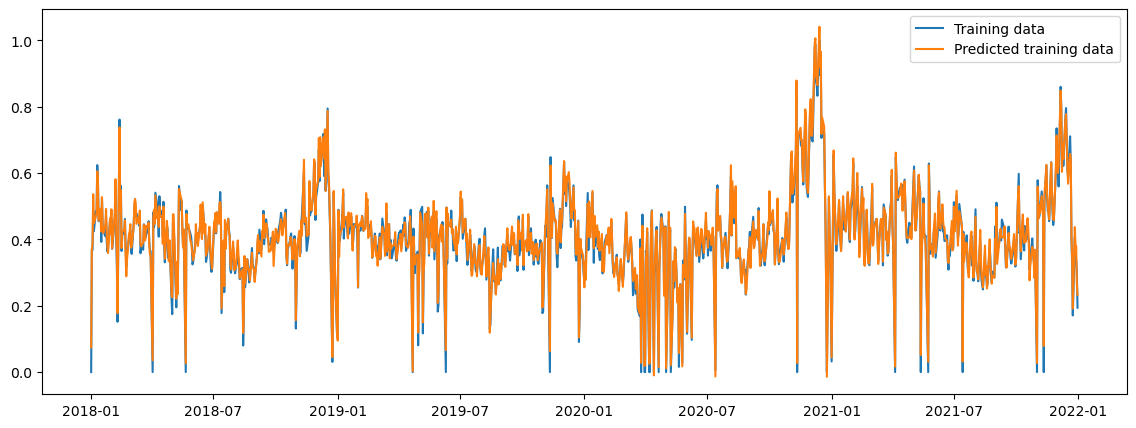

In [68]:
import matplotlib.pyplot as plt
# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(train_complete_dates, y_train_complete, label='Training data')
plt.plot(train_complete_dates, y_train_pred, label='Predicted training data')
plt.legend()
plt.show()

In [69]:
import matplotlib.pyplot as plt


# Get the traffic scaler
traffic_scaler = scaler['tg1_traffic']

# Reshape the predictions and the targets to the original shape
y_train_pred_rescaled = traffic_scaler.inverse_transform(y_train_pred)
y_train_rescaled = traffic_scaler.inverse_transform(y_train_complete.reshape(-1,1))

# Créez un masque pour filtrer les valeurs où y_true est égal à zéro
mask_train = y_train_rescaled != 0


# Calculez le MAPE en excluant les valeurs où y_true est égal à zéro
mape_train = np.mean(np.abs(y_train_rescaled[mask_train] - y_train_pred_rescaled[mask_train]) / y_train_rescaled[mask_train] * 100)

# Affichez les valeurs de MAPE
print(f'MAPE on Training Data: {mape_train:.2f}%')


MAPE on Training Data: 4.64%
